<a href="https://colab.research.google.com/github/haticerdogan/Seattle-Airbnb-Recommender/blob/main/Airbnb_Seattle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! git clone https://github.com/haticerdogan/Seattle-Airbnb-Project.git

Cloning into 'Seattle-Airbnb-Project'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 20 (delta 2), reused 10 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [ ]:
%cd 'Seattle-Airbnb-Project'

/content/Seattle-Airbnb-Project


## HOME AWAY FROM HOME


Airbnb, which is short for "Air Bed and Breakfast", is an online platform that makes it easy to list and rent local homes by connecting hosts and guests. Seattle, WA is one of the most urban and modern cities in the United States. As many people visit Seattle, demand for searching and booking Airbnb listings increases.

The purpose of this project is to predict the booking rates of listings based on their features and provide Airbnb hosts with insights that will increase both booking rates and guests' pleasure with valuable improvements.

The process starts with cleaning the data, pre-processing and vectorizing the text columns followed by a Machine Learning pipeline using regression algorithms that predict the booking rate of Airbnb listings in the Seattle Metro area. Models predict the mean booking rate for a given property listing for the year. Baseline regression models are evaluated first hyperparameters are tuned with RandomizedSeachCV to find the optimal hyperparameters with the lowest cross validated Mean Squared Error (MSE). The independent variables affecting the booking rate of listings consists of 3 components:

1. Text columns that give an overview of each listing on Airbnb which are preprocessed and vectorized using Natural Language Processing (NLP).
2. Numerical columns such as cleaning fee, daily price and price for additional people.
3. Categorical columns such as whether host of a particular listing is a superhost or not, bed type, and property type.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns" , None)
import warnings
warnings.filterwarnings('ignore')

### Preprocessing Calendar Data

In [ ]:
calendar = pd.read_csv('Data/calendar.csv')
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [ ]:
# Lots of null values in price column since it is daily data, we do not expect it to change a lot 
# I will be forward filling null values so if there is a change in price the next row would be filled with changed price
calendar.isna().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

Prediction target is yearly booking rate for a listing. Using available column, I assigned 0 for available listings and 1 for unavailable which will show whether a listing was booked or not for a given day.

In [ ]:
# Forward filling null values in price column and removing $ sign 
# Binary mapping for available column whether it is booked or not 
calendar['price'] = calendar['price'].replace('[\$,]','',regex=True).astype(float)
calendar['price'] = calendar['price'].fillna(method='ffill')
calendar['booked'] = calendar['available'].map({'t': 0, 'f': 1})
calendar.drop('available', axis = 1, inplace = True)

In [ ]:
calendar.head()

,listing_id,date,price,booked
0,241032,2016-01-04,85.0,0
1,241032,2016-01-05,85.0,0
2,241032,2016-01-06,85.0,1
3,241032,2016-01-07,85.0,1
4,241032,2016-01-08,85.0,1


In [ ]:
# Taking mean booking rate of each listing 
calendar['booking_rate'] = calendar[['listing_id', 'booked']].groupby('listing_id').mean()
# Average booking rate per day 
booking_rate_trends = calendar[['date', 'booked']].groupby(['date']).mean().reset_index()
booking_rate_trends.head()

,date,booked
0,2016-01-04,0.545574
1,2016-01-05,0.511001
2,2016-01-06,0.521739
3,2016-01-07,0.534835
4,2016-01-08,0.533263


In [ ]:
import plotly.express as px

fig = px.line(booking_rate_trends, x="date", y="booked", title='Occupancy Trend in Seattle, WA')
fig.show()

The above graph shows the average daily booking rate throughout the year 2016 to 2017. We see three distinct periods with dramatic increases. The data starts with New Years and it appears to be the time with the greatest increase in booking rate since it decreaes a lot until March 2016. The second peak is in April which we can assume as Spring Break. The last one is in July presumably summer vacations.

In [ ]:
# Average price per day 
price_trends = calendar[['date', 'price']].groupby(['date']).mean().reset_index()
price_trends.head()

,date,price
0,2016-01-04,127.514144
1,2016-01-05,126.352017
2,2016-01-06,125.211105
3,2016-01-07,124.999476
4,2016-01-08,127.181771


In [ ]:
# Average price of listings from 2016 to 2017
fig = px.line(price_trends, x="date", y="price", title='Price Trend in Seattle, WA')
fig.show()

The above graph shows the average daily price. We see an increase in price starting on March and peaking between the middle of May and September. This is probably due to demand in booking. As excess demand will cause price to rise, hosts increase their price.

### Preprocessing Listings Dataset

In [ ]:
df = pd.read_csv('Data/listings.csv')
df.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [ ]:
# Dataset contains 3818 unique listings and 92 columns
df.shape

(3818, 92)

## Pre-processing Data

A lot of columns in the data does not provide much information about the booking rate of the listings. Instead of dropping bunch of columns I will be using only the columns I need for modeling. 

The data pre-processing will be broken into two parts:

1) Natural language processing will be applied to columns describing the listings.

2) Cleaning and preparing categorical and numerical columns.


In [ ]:
df = pd.read_csv('Data/listings.csv', usecols = ['id', 'name', 'summary', 'space', 'description', 'neighborhood_overview','notes','transit', 'price', 'extra_people', 
                                                 'security_deposit', 'cleaning_fee','maximum_nights', 'minimum_nights', 'number_of_reviews', 'cancellation_policy',
                                                 'review_scores_rating', 'review_scores_cleanliness', 'guests_included', 'bed_type', 'beds', 'bathrooms', 
                                                 'host_is_superhost', 'host_response_time', 'bedrooms', 'accommodates', 'room_type', 'property_type', 'neighbourhood_group_cleansed'])

In [ ]:
# Getting average yearly booking rate for each listing and merging it with the listing data 
booking_rate = calendar[['listing_id', 'booked']].groupby('listing_id').mean()
df = pd.merge(left = df, right = booking_rate, left_on = 'id', right_index = True)

#Renaming column name
df.rename(columns ={'booked': 'booking_rate'}, inplace = True)
df.head(2)

,id,name,summary,space,description,neighborhood_overview,notes,transit,host_response_time,host_is_superhost,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_cleanliness,cancellation_policy,booking_rate
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,within a few hours,f,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,$85.00,NaN,NaN,2,$5.00,1,365,207,95.0,10.0,moderate,0.052055
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",within an hour,t,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,$150.00,$100.00,$40.00,1,$0.00,2,90,43,96.0,10.0,strict,0.202740


In [ ]:
# 30 columns will be used for modeling.
df.shape

(3818, 30)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            3818 non-null   int64  
 1   name                          3818 non-null   object 
 2   summary                       3641 non-null   object 
 3   space                         3249 non-null   object 
 4   description                   3818 non-null   object 
 5   neighborhood_overview         2786 non-null   object 
 6   notes                         2212 non-null   object 
 7   transit                       2884 non-null   object 
 8   host_response_time            3295 non-null   object 
 9   host_is_superhost             3816 non-null   object 
 10  neighbourhood_group_cleansed  3818 non-null   object 
 11  property_type                 3817 non-null   object 
 12  room_type                     3818 non-null   object 
 13  acc

In [ ]:
df.isna().sum()

id                                 0
name                               0
summary                          177
space                            569
description                        0
neighborhood_overview           1032
notes                           1606
transit                          934
host_response_time               523
host_is_superhost                  2
neighbourhood_group_cleansed       0
property_type                      1
room_type                          0
accommodates                       0
bathrooms                         16
bedrooms                           6
beds                               1
bed_type                           0
price                              0
security_deposit                1952
cleaning_fee                    1030
guests_included                    0
extra_people                       0
minimum_nights                     0
maximum_nights                     0
number_of_reviews                  0
review_scores_rating             647
r

1) Natural Language Processing for Text Columns

In [ ]:
# Fill missing values with empty strings. When we combine the rows as one row for each listing, null values will have no effect. 
df['summary'] = df['summary'].fillna('')
df['space'] = df['space'].fillna('')
df['neighborhood_overview'] = df['neighborhood_overview'].fillna('')
df['notes'] = df['notes'].fillna('')
df['transit'] = df['transit'].fillna('')

In [ ]:
# Creating a new column that combines all the columns with descriptions of the listings
df['content'] = df['name'] + ' ' + df['summary'] + ' ' + df['space'] + ' ' + df['description'] + ' ' + df['neighborhood_overview'] + ' ' + df['notes'] + ' ' + df['transit']
df['content'].head()

0    Stylish Queen Anne Apartment  Make your self a...
1    Bright & Airy Queen Anne Apartment Chemically ...
2    New Modern House-Amazing water view New modern...
3    Queen Anne Chateau A charming apartment that s...
4    Charming craftsman 3 bdm house Cozy family cra...
Name: content, dtype: object

In [ ]:
df['content'][0]

"Stylish Queen Anne Apartment  Make your self at home in this charming one-bedroom apartment, centrally-located on the west side of Queen Anne hill.   This elegantly-decorated, completely private apartment (bottom unit of a duplex) has an open floor plan, bamboo floors, a fully equipped kitchen, a TV,  DVD player, basic cable, and a very cozy bedroom with a queen-size bed. The unit sleeps up to four (two in the bedroom and two on the very comfortable fold out couch, linens included) and includes free WiFi and laundry. The apartment opens onto a private deck, complete with it's own BBQ, overlooking a garden and a forest of black bamboo.    The Apartment is perfectly-located just one block from the bus lines where you can catch a bus and be downtown Seattle in fifteen minutes or historic Ballard in ten or a quick five-minute walk will bring you to Whole Foods and Peet's Coffee or take a fifteen minute walk to the top of Queen Anne Hill where you will find a variety of eclectic shops, bar

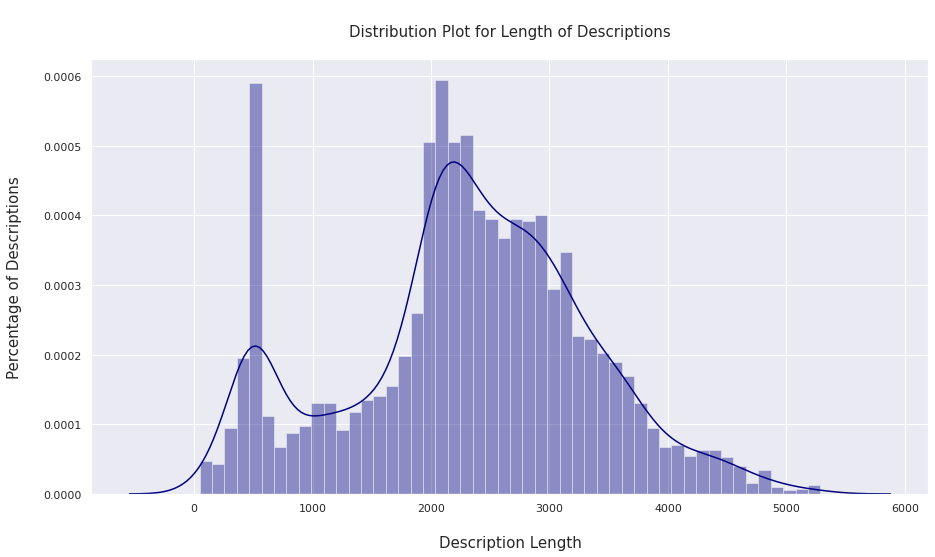

In [ ]:
# Distribution plot that shows the lentgth of each descriptions 
df_content = df['content'].apply(len)
df_content

sns.set_theme(style='darkgrid')
#sns.set_color_codes('pastel')
plt.figure(figsize=(15, 8))

sns.distplot(df_content, kde=True, bins=50, color='navy')

plt.title('\nDistribution Plot for Length of Descriptions\n', fontsize=15)
plt.xlabel('\nDescription Length', fontsize=15)
plt.ylabel('Percentage of Descriptions\n', fontsize=15);

In [ ]:
! pip install contractions

In [ ]:
# Contractions are words or combinations of words that are shortened by dropping letters and replacing them by an apostrophe.
# Removing contractions to standardize text 

import contractions
expanded_words = []   
for word in df['content']:
# Using contractions.fix to expand the shortened words
  expanded_words.append(contractions.fix(word))  
   
df['content'] = expanded_words

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import re
import string
# Creating a function that will preprocess and standardize the text for NLP 
def preprocess(text):
    ''' This function takes text to preprocess and standardize it for the purpose of NLP '''
 
    # Lowercase the text 
    text = text.str.lower()
    
    # Remove punctuations using string module with regular expression
    text = text.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

    # Remove word and digits 
    #text = text.apply(lambda x: re.sub('W*dw*','', x))

    # Split string by whitespace and remoce extra whitespaces 
    text = text.apply(lambda x: x.split())

    # Remove stopwords 
    import nltk
    stopwords = nltk.corpus.stopwords.words('english')
    text = text.apply(lambda x: [word for word in x if word not in stopwords])

    # Lemmatize text to group together words with the same root or lemma
    from nltk.stem.wordnet import WordNetLemmatizer
    lemmatizer = nltk.stem.WordNetLemmatizer()
    text = text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    text = text.apply(lambda x: ' '.join(x))

    return text

In [ ]:
# Applying NLP preprocessing function to content column 
df['content'] = preprocess(df['content'])
df['content'][0]

'stylish queen anne apartment make self home charming one bedroom apartment centrally located west side queen anne hill elegantly decorated completely private apartment bottom unit duplex open floor plan bamboo floor fully equipped kitchen tv dvd player basic cable cozy bedroom queen size bed unit sleep four two bedroom two comfortable fold couch linen included includes free wifi laundry apartment open onto private deck complete bbq overlooking garden forest black bamboo apartment perfectly located one block bus line catch bus downtown seattle fifteen minute historic ballard ten quick five minute walk bring whole food peet coffee take fifteen minute walk top queen anne hill find variety eclectic shop bar restaurant make self home charming one bedroom apartment centrally located west side queen anne hill elegantly decorated completely private apartment bottom unit duplex open floor plan bamboo floor fully equipped kitchen tv dvd player basic cable cozy bedroom queen size bed unit sleep 

In [ ]:
# Feature engineering: adding length of content to dataframe as it may have influence on booking rate
df['content_len'] = df['content'].apply(len)

In [ ]:
# Dropping columns that are combined into content column
df.drop(['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit'], axis=1, inplace = True)

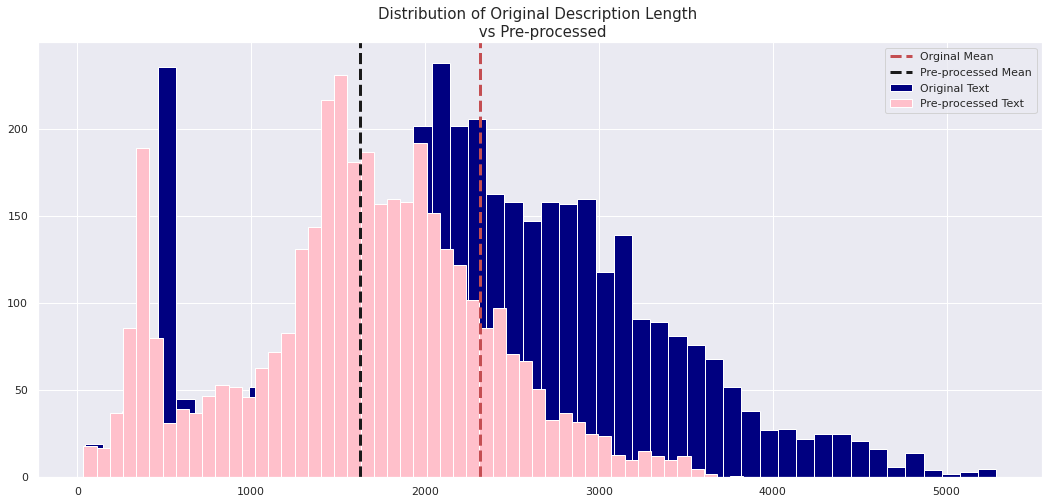

In [ ]:
# Distribution plot that shows the difference between length of original text versus pre-processed text
sns.set_theme(style='darkgrid')
#sns.set_color_codes('pastel')
plt.figure(figsize=(18, 8))

plt.hist(df_content, bins=50, color='navy', label='Original Text')
plt.hist(df['content_len'], bins=50, color='pink', label='Pre-processed Text')
plt.axvline(df_content.mean(), color='r', linestyle='dashed', linewidth=3, label='Orginal Mean')
plt.axvline(df['content_len'].mean(), color='k', linestyle='dashed', linewidth=3, label='Pre-processed Mean')
plt.legend()
plt.title('Distribution of Original Description Length \n vs Pre-processed', fontsize=15);

2.1) Preparing Categorical Columns

In [ ]:
df['host_response_time'].value_counts()

within an hour        1692
within a few hours     968
within a day           597
a few days or more      38
Name: host_response_time, dtype: int64

In [ ]:
df['host_is_superhost'].value_counts()

f    3038
t     778
Name: host_is_superhost, dtype: int64

In [ ]:
df['bedrooms'].value_counts()

1.0    2417
2.0     640
0.0     372
3.0     283
4.0      69
5.0      24
6.0       6
7.0       1
Name: bedrooms, dtype: int64

In [ ]:
# Replacing null values with median rating
df['review_scores_rating'] = df['review_scores_rating'].fillna(df['review_scores_rating'].median())
# Binning scores to categories and changing data type 
df['review_scores_rating_'] = pd.cut(df['review_scores_rating'], [50.0, 70.0, 70.0, 80.0, 80.0, 90.0, 90.0, 100.0],
                             labels = ['50-70', '70-80', '80-90', '90-100'], duplicates = 'drop')
# Changing data type of categorical features 
df['review_scores_rating_'] = df['review_scores_rating_'].astype(object)
df['guests_included'] = df['guests_included'].astype(object)
df['review_scores_cleanliness'] = df['review_scores_rating'].fillna(df['review_scores_rating'].median())
df['review_scores_cleanliness'] = df['review_scores_cleanliness'].astype(int).astype(object)

# Binary mapping whether host is superhost or not 
df['host_is_superhost'] = df['host_is_superhost'].map({'t': 1, 'f': 0})
# Replacing null values with median rating
df['host_is_superhost'] = df['host_is_superhost'].fillna(df['host_is_superhost'].median())
df['host_is_superhost'] = df['host_is_superhost'].astype(int).astype(object)
# Dropping id as it has no effect on booking rate
df.drop(['review_scores_rating', 'id'], axis=1, inplace=True)

2.2) Preparing Numerical Columns 



In [ ]:
# Cleaning columns with price and changing data type
df['price'] = df['price'].replace('[\$,]','',regex=True).astype(float)
df['cleaning_fee'] = df['cleaning_fee'].replace('[\$,]','',regex=True).astype(float)
df['security_deposit'] = df['security_deposit'].replace('[\$,]','',regex=True).astype(float)
df['extra_people'] = df['extra_people'].replace('[\$,]','',regex=True).astype(float)

In [ ]:
df.dtypes

host_response_time               object
host_is_superhost                object
neighbourhood_group_cleansed     object
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                       float64
bedrooms                        float64
beds                            float64
bed_type                         object
price                           float64
security_deposit                float64
cleaning_fee                    float64
guests_included                  object
extra_people                    float64
minimum_nights                    int64
maximum_nights                    int64
number_of_reviews                 int64
review_scores_cleanliness        object
cancellation_policy              object
booking_rate                    float64
content                          object
content_len                       int64
review_scores_rating_            object
dtype: object

In [ ]:
df.shape

(3818, 24)

In [ ]:
df.to_pickle("Data/preprocessed_df.pkl")  

## Data Modeling 

In [ ]:
# Import Python packages and modules to use 
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR 
from sklearn.inspection import permutation_importance

In [ ]:
# Splitting data into train and test sets
X = df.drop('booking_rate', axis=1)
y = df['booking_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## TF-IDF Vectorizer

Please refer to NLP-Recommender notebook to see different vectorizers applied on text data. 

In [ ]:
# Use TF-IDF Vectorizer for models 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', lowercase=False, ngram_range=(1,3))


# Machine Learning Pipeline 

Three different pipelines are created and then combined in column transformer.

1) Numerical variables will be scaled with Standard Scaler and null variables will be filled with Simple Imputer using median of each column. 

2) Categorical variables will be One Hot Encoded and null variables will be filled with constant value of each columnn.

3) Pre-processed text data is vectorized with TF-IDF.

In [ ]:
# Selecting numerical and categorical columns 
#cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
#num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Pipeline for numerical data
num_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                     ("scaler", StandardScaler())])
# Pipeline for categorical data  
cat_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant")),
                        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))])
# Pipeline for the content column 
text_pipeline = Pipeline(steps=[('Text', tfidf)])

# Assign categorical and numerical columns to their respective pipeline
# Add vectorized content column to the ColumnTransformer
preprocessing = ColumnTransformer(
    transformers=[("num", num_pipeline, [5,6,7,8,10,11,12,14,15,16,17,21]), 
                  ("cat", cat_pipeline, [0,1,2,3,4,9,13,18,19,22]),
                  ("tfidf", text_pipeline, "content")])

In [ ]:
def run_models(model, type_):
    ''' This function takes preprocessing pipeline from above to train the data on 7 different Machine Learning Models
    then return RMSE and MSE score of each model'''

    metric_table = pd.DataFrame(columns=['Model', 'RMSE', 'MSE', ' Type'])

    for name, model in model.items():
        print(f'{name} Model:')
        pipeline = Pipeline(
            steps=[("preprocess", preprocessing), ('regressor', model['regressor'])])
        
        pipeline.fit(X_train, y_train) 

        y_pred = pipeline.predict(X_test)

        #cv_mse = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='mean_squared_error')
        #cv_mse_mean = (cv_mse).mean()

        rmse = mean_squared_error(y_test, y_pred, squared=False)

        mse = mean_squared_error(y_test, y_pred)
            
        metric_table = metric_table.append({'Model': name, 'RMSE': round(rmse, 4), 'MSE': round(mse, 4), 'Type': type_}, ignore_index=True)
      
        print(f'RMSE Score: {metric_table.iloc[-1,1]}')
        print(f'MSE Score: {metric_table.iloc[-1,2]}\n')
    
    return metric_table

In [ ]:
# Create a dictionary of the baseline models to run
baseline_models = {'LinearRegression':
                  {'regressor': LinearRegression()},

                'SGDRegressor':
                  {'regressor': SGDRegressor(random_state=42)},
               
               'DecisionTree':
                  {'regressor': DecisionTreeRegressor(random_state=42)},
               
               'RandomForest':
                  {'regressor': RandomForestRegressor(random_state=42)},
               
               'ExtraTrees':
                  {'regressor': ExtraTreesRegressor(random_state=42)},
               
               'GradientBoost':
                  {'regressor': GradientBoostingRegressor(random_state=42)},
                   
               'SVR':
                  {'regressor': SVR()}}

In [ ]:
# Use function created above to run the baseline models
models_table = run_models(baseline_models, 'Baseline')
models_table

LinearRegression Model:
RMSE Score: 0.8193
MSE Score: 0.6713

SGDRegressor Model:
RMSE Score: 0.3497
MSE Score: 0.1223

DecisionTree Model:
RMSE Score: 0.4631
MSE Score: 0.2144

RandomForest Model:
RMSE Score: 0.3295
MSE Score: 0.1086

ExtraTrees Model:
RMSE Score: 0.3415
MSE Score: 0.1166

GradientBoost Model:
RMSE Score: 0.3361
MSE Score: 0.113

SVR Model:
RMSE Score: 0.3274
MSE Score: 0.1072



,Model,RMSE,MSE,Type,Type
0,LinearRegression,0.8193,0.6713,NaN,Baseline
1,SGDRegressor,0.3497,0.1223,NaN,Baseline
2,DecisionTree,0.4631,0.2144,NaN,Baseline
3,RandomForest,0.3295,0.1086,NaN,Baseline
4,ExtraTrees,0.3415,0.1166,NaN,Baseline
5,GradientBoost,0.3361,0.1130,NaN,Baseline
6,SVR,0.3274,0.1072,NaN,Baseline


Linear regression performed worst with Mean Squared Error of 0.67 whereas RandomForest and SVR scored 0.10

## Hyperparameter Tuning with RandomizedSearchCV

---

RandomizedSearchCV will be used to find optimal hyperparameters for the best performing models. 

## Stochastic Gradient Descent (SGD) Regressor

---



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
pipe_sgd = Pipeline(steps=[("preprocess", preprocessing), 
                                    ("sgd", SGDRegressor())])

sgd_grid = [{'sgd__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'sgd__loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
            'sgd__penalty': ['l2', 'l1', 'elasticnet'],
            'sgd__learning_rate': ['constant', 'optimal', 'invscaling']}]

sgd_RandomGrid = RandomizedSearchCV(estimator = pipe_sgd, 
                          param_distributions = sgd_grid, 
                          scoring='neg_mean_squared_error',
                          n_jobs = -1, 
                          cv = 2,
                          n_iter = 1,
                          verbose = 1)

sgd_RandomGrid.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               [5,
                                                                                6,
                                                                                7,
                                                                                8,
                                    

In [ ]:
print('Best Parameters:', sgd_RandomGrid.best_params_)
print('Best Mean Squared Error:', round((sgd_RandomGrid.best_score_ * -1), 4))

Best Parameters: {'sgd__penalty': 'l2', 'sgd__loss': 'squared_loss', 'sgd__learning_rate': 'invscaling', 'sgd__alpha': 100}
Best Mean Squared Error: 0.1812


## Support Vector Regressor 

In [ ]:
pipe_svr = Pipeline(steps=[("preprocess", preprocessing), 
                                    ("svr", SVR(kernel='rbf'))])
svr_grid = [{'svr__C': [0.01, 0.5, 0.1, 1, 3, 5], 
         'svr__gamma': [0.01, 0.5, 0.1, 0.3, 0.5]}]


svr_RandomGrid = RandomizedSearchCV(estimator = pipe_svr, 
                          param_distributions = svr_grid, 
                          scoring='neg_mean_squared_error',
                          n_jobs = -1, 
                          cv = 2,
                          n_iter = 1,
                          verbose = 1)

svr_RandomGrid.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               [5,
                                                                                6,
                                                                                7,
                                                                                8,
                                    

In [ ]:
print('Best Parameters:', svr_RandomGrid.best_params_)
print('Best Mean Squared Error:', round((svr_RandomGrid.best_score_ * -1), 4))

Best Parameters: {'svr__gamma': 0.3, 'svr__C': 0.01}
Best Mean Squared Error: 0.1388


In [ ]:
pipe_svr = Pipeline(steps=[("preprocess", preprocessing), 
                                    ("svr", SVR(kernel='rbf'))])
svr_grid1 = [{'svr__C': [0.001, 0.01, 0.1, 0.5, 1, 3, 5, 10], 
         'svr__gamma': [0.01, 0.01, 0.5, 0.1, 0.3, 0.5, 1.0, 10, 100]}]


svr_RandomGrid1 = RandomizedSearchCV(estimator = pipe_svr, 
                          param_distributions = svr_grid1, 
                          scoring='neg_mean_squared_error',
                          n_jobs = -1, 
                          cv = 2,
                          n_iter = 1,
                          verbose = 1)

svr_RandomGrid1.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               [5,
                                                                                6,
                                                                                7,
                                                                                8,
                                    

In [ ]:
print('Best Parameters:', svr_RandomGrid1.best_params_)
print('Best Mean Squared Error:', round((svr_RandomGrid1.best_score_ * -1), 4))

Best Parameters: {'svr__gamma': 0.01, 'svr__C': 0.1}
Best Mean Squared Error: 0.1247


## Extra Trees Regressor

In [ ]:
pipe_et = Pipeline(steps=[("preprocess", preprocessing), 
                                    ("et", ExtraTreesRegressor(random_state = 42))])

et_grid = [{'et__n_estimators': [1000, 1100, 1200, 1300, 1400, 1500], 
         'et__min_samples_split': [1.0, 5, 10, 15],
         'et__max_depth': [10, 13, 15, 18, 20]}]


et_RandomGrid = RandomizedSearchCV(estimator = pipe_et, 
                          param_distributions = et_grid, 
                          scoring ='neg_mean_squared_error',
                          n_jobs = -1,
                          n_iter = 1, 
                          cv = 2,
                          verbose = 1)

et_RandomGrid.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               [5,
                                                                                6,
                                                                                7,
                                                                                8,
                                    

In [ ]:
print('Best Parameters:', et_RandomGrid.best_params_)
print('Best Mean Squared Error:', round((et_RandomGrid.best_score_ * -1), 4))

Best Parameters: {'et__n_estimators': 1000, 'et__min_samples_split': 10, 'et__max_depth': 20}
Best Mean Squared Error: 0.1135


## Random Forest Regressor 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
pipe_rf = Pipeline(steps=[("preprocess", preprocessing), 
                                    ("rf", RandomForestRegressor(random_state = 42))])
rf_grid = {'rf__n_estimators': [1000, 1200, 1300, 1400, 1500],
               'rf__max_features': ['auto', 'log2'],
               'rf__min_samples_split': [1.0, 5, 10, 15],
               'rf__max_depth': [3, 5, 10, 15]}
rf_RandomGrid = RandomizedSearchCV(estimator = pipe_rf, 
                                   param_distributions = rf_grid, 
                                   scoring ='neg_mean_squared_error',
                                   cv = 2, 
                                   n_jobs = -1,
                                   n_iter = 1,
                                   verbose = 1)
rf_RandomGrid.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               [5,
                                                                                6,
                                                                                7,
                                                                                8,
                                    

In [ ]:
print('Best Parameters:', rf_RandomGrid.best_params_)
print('Best Mean Squared Error:', round((rf_RandomGrid.best_score_ * -1), 4))

Best Parameters: {'rf__n_estimators': 1500, 'rf__min_samples_split': 10, 'rf__max_features': 'log2', 'rf__max_depth': 3}
Best Mean Squared Error: 0.1197


In [ ]:
pipe_rf = Pipeline(steps=[("preprocess", preprocessing), 
                                    ("rf", RandomForestRegressor(random_state = 42))])
rf_grid1 = {'rf__n_estimators': [500, 700, 800, 1000, 1100, 1200, 1300, 1400, 1500],
               'rf__max_features': ['auto', 'log2'],
               'rf__min_samples_split': [1.0, 5, 10, 15],
               'rf__max_depth': [5, 10, 12, 14, 15, 18]}
rf_RandomGrid1 = RandomizedSearchCV(estimator = pipe_rf, 
                                   param_distributions = rf_grid1, 
                                   scoring ='neg_mean_squared_error',
                                   cv = 2, 
                                   n_jobs = -1,
                                   n_iter = 1,
                                   verbose = 1)
rf_RandomGrid1.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               [5,
                                                                                6,
                                                                                7,
                                                                                8,
                                    

In [ ]:
print('Best Parameters:', rf_RandomGrid1.best_params_)
print('Best Mean Squared Error:', round((rf_RandomGrid1.best_score_ * -1), 4))

Best Parameters: {'rf__n_estimators': 1000, 'rf__min_samples_split': 1.0, 'rf__max_features': 'auto', 'rf__max_depth': 5}
Best Mean Squared Error: 0.12


In [ ]:
rf_model = Pipeline(steps=[("preprocess", preprocessing), 
                  ('svr', RandomForestRegressor(random_state = 2022, max_features = 'sqrt', n_estimators = 1300))])
rf_model.fit(X_train, y_train)
cv_rf = cross_val_score(rf_model, X_train, y_train, scoring='neg_mean_squared_error', cv=2)
print('Cross Validation Score Array:', cv_rf * -1)
print('Average CV:', round(-cv_rf.mean(), 4))

Cross Validation Score Array: [0.1062035  0.11967331]
Average CV: 0.1129


## Gradient Boosting Regressor

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
pipe_gbr = Pipeline(steps=[("preprocess", preprocessing), 
                                    ("gbr", GradientBoostingRegressor(random_state = 42))])
gbr_grid = {'gbr__n_estimators': [500, 700, 800, 1000, 1100, 1200, 1300, 1400, 1500],
               'gbr__max_features': range(7,20,2),
               'gbr__min_samples_split': [1.0, 5, 10, 15],
               'gbr__max_depth': [5, 10, 12, 14, 15, 18]}
gbr_RandomGrid = RandomizedSearchCV(estimator = pipe_gbr, 
                                   param_distributions = gbr_grid, 
                                   scoring ='neg_mean_squared_error',
                                   cv = 2, 
                                   n_jobs = -1,
                                   n_iter = 1,
                                   verbose = 1)
gbr_RandomGrid.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               [5,
                                                                                6,
                                                                                7,
                                                                                8,
                                    

In [ ]:
print('Best Parameters:', gbr_RandomGrid.best_params_)
print('Best Mean Squared Error:', round((gbr_RandomGrid.best_score_ * -1), 4))

Best Parameters: {'gbr__n_estimators': 800, 'gbr__min_samples_split': 10, 'gbr__max_features': 17, 'gbr__max_depth': 18}
Best Mean Squared Error: 0.1148


In [ ]:
pipe_gbr = Pipeline(steps=[("preprocess", preprocessing), 
                                    ("gbr", GradientBoostingRegressor(random_state = 42))])
gbr_grid1 = {'gbr__n_estimators': [40, 50, 60, 70],
               'gbr__max_features': range(7,20,2),
               'gbr__min_samples_split': range(1000,2100,200),
               'gbr__max_depth': [6, 8, 10, 12, 13, 14, 15]}
gbr_RandomGrid1 = RandomizedSearchCV(estimator = pipe_gbr, 
                                   param_distributions = gbr_grid1, 
                                   scoring ='neg_mean_squared_error',
                                   cv = 2, 
                                   n_jobs = -1,
                                   n_iter = 1,
                                   verbose = 1)
gbr_RandomGrid1.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               [5,
                                                                                6,
                                                                                7,
                                                                                8,
                                    

In [ ]:
print('Best Parameters:', gbr_RandomGrid1.best_params_)
print('Best Mean Squared Error:', round((gbr_RandomGrid1.best_score_ * -1), 4))

Best Parameters: {'gbr__n_estimators': 40, 'gbr__min_samples_split': 2000, 'gbr__max_features': 11, 'gbr__max_depth': 10}
Best Mean Squared Error: 0.12


## Decision Tree Regressor

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
pipe_dt = Pipeline(steps=[("preprocess", preprocessing), 
                                    ("dt", DecisionTreeRegressor(random_state = 42))])
dt_grid = {'dt__criterion': ["friedman_mse", "squared_error", "absolute_error"],
               'dt__max_features': range(7,20,2),
               'dt__min_samples_split': [1.0, 5, 10, 15],
               'dt__max_depth': [10, 15, 20, 25, 30]}
dt_RandomGrid = RandomizedSearchCV(estimator = pipe_dt, 
                                   param_distributions = dt_grid, 
                                   scoring ='neg_mean_squared_error',
                                   cv = 2, 
                                   n_jobs = -1,
                                   n_iter = 1,
                                   verbose = 1)
dt_RandomGrid.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               [5,
                                                                                6,
                                                                                7,
                                                                                8,
                                    

In [ ]:
print('Best Parameters:', dt_RandomGrid.best_params_)
print('Best Mean Squared Error:', round((dt_RandomGrid.best_score_ * -1), 4))

Best Parameters: {'dt__min_samples_split': 5, 'dt__max_features': 19, 'dt__max_depth': 10, 'dt__criterion': 'absolute_error'}
Best Mean Squared Error: 0.1521


## Final Model Selection 

The best model was Support Vector Regression with tuned hyperparameters.

In [ ]:
models = {'Linear Regression \n Baseline': 0.6713,
          'Decision Tree \n Baseline': 0.2144,
          'SGD Regressor \n Tuned': 0.1812,
          'Decision Tree \n Tuned': 0.1521,
          'Gradient Boosting \n Tuned': 0.1148,
          'Extra Trees \n Tuned': 0.1135,
          'Random Forest \n Baseline': 0.1086,
          'SVR Tuned': 0.108}

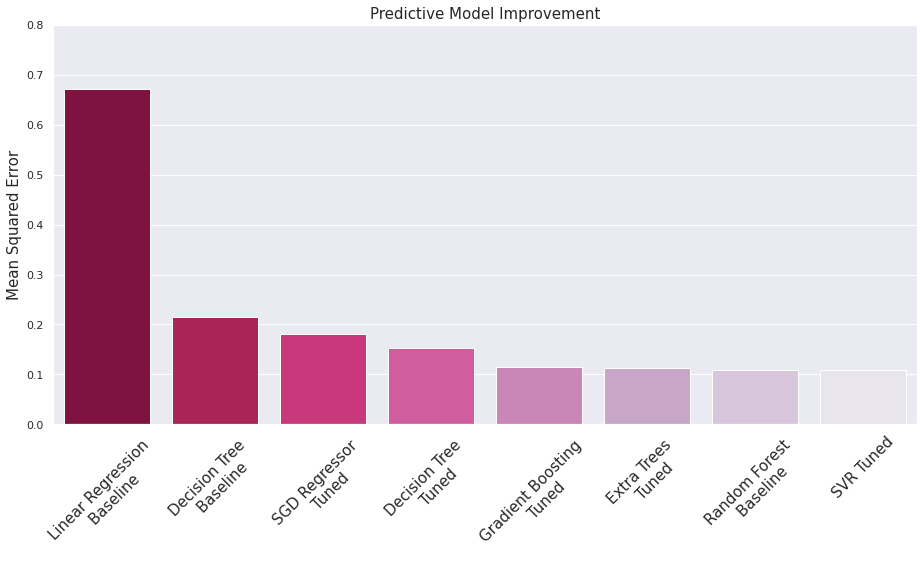

In [ ]:
fig, ax = plt.subplots(figsize=(13, 8))
fig.set_tight_layout(True)
sns.set_style('darkgrid')

xticklabels = list(models.keys())
y = list(models.values())

sns.barplot(x=xticklabels, y=y, palette='PuRd_r')
ax.set(ylim=(0, 0.8))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='center', fontsize=15)
ax.set_ylabel('Mean Squared Error', fontsize=15)
ax.set_title('Predictive Model Improvement', fontsize=15);


In [ ]:
# Support Vector Regression
svr_model = Pipeline(steps=[("preprocess", preprocessing), 
                  ('svr', SVR(C = 1, gamma=0.1))])
svr_model.fit(X_train, y_train)
cv_svr = cross_val_score(svr_model, X_train, y_train, scoring='neg_mean_squared_error', cv=2)
print('Cross Validation Score Array:', cv_svr * -1)
print('Average CV:', round(-cv_svr.mean(), 4))

Cross Validation Score Array: [0.105286   0.11238067]
Average CV: 0.1088


In [ ]:
print('Best Model: Support Vector Regressor')
svr_y_pred = svr_model.predict(X_test)
print('Test Mean Squared Error:', round((mean_squared_error(y_test, svr_y_pred)), 4))

Best Model: Support Vector Regressor
Test Mean Squared Error: 0.1076


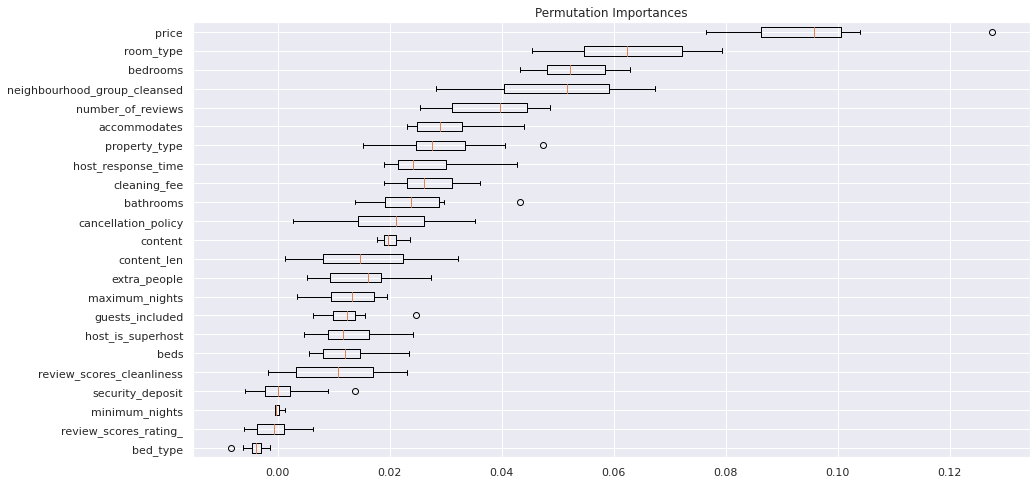

In [ ]:
# Permutation Importance of SVR 
result = permutation_importance(svr_model, X_test, y_test, n_repeats = 10, random_state =  2022)
sorted_index = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15, 8))
ax.boxplot(result.importances[sorted_index].T, vert=False, labels=X.columns[sorted_index])

ax.set_title('Permutation Importances')
fig.show()

In [ ]:
perm_features = pd.DataFrame(dict(feature_names = X_test.columns.tolist(),
                                  feature_importance = result.importances_mean))
# Displaying importances from highest to lowest
perm_features.sort_values('feature_importance', ascending=False)

,feature_names,feature_importance
10,price,0.095479
4,room_type,0.063029
7,bedrooms,0.053042
2,neighbourhood_group_cleansed,0.049726
17,number_of_reviews,0.038116
5,accommodates,0.030693
3,property_type,0.029652
0,host_response_time,0.027453
12,cleaning_fee,0.027358
6,bathrooms,0.024658


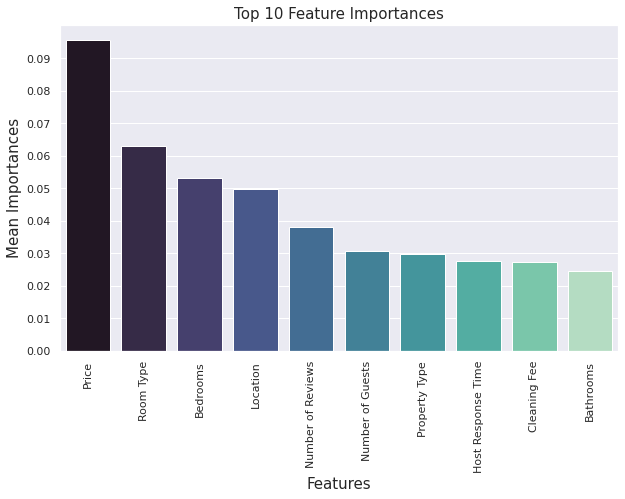

In [ ]:
# The most important features for SVR
top_features = perm_features.sort_values('feature_importance', ascending=False)[0:10]
top_names = ['Price', 'Room Type', 'Bedrooms', 'Location', 'Number of Reviews', 'Number of Guests',
             'Property Type', 'Host Response Time', 'Cleaning Fee', 'Bathrooms']
plt.figure(figsize=(10, 6))

ax = sns.barplot(x='feature_names', y='feature_importance', data=top_features, palette='mako')
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('Mean Importances', fontsize=15)
ax.set_title('Top 10 Feature Importances', fontsize=15)
plt.xticks(range(len(top_names)), top_names, rotation=90, ha='center')
plt.yticks(np.arange(0, 0.1, step=0.010))
plt.show()

In [95]:
# Permutation Importance of Random Forest
rf_bestmodel = Pipeline(steps=[("preprocess", preprocessing), 
                  ('rf', RandomForestRegressor(random_state = 2022))])
rf_bestmodel.fit(X_train, y_train)
rf_y_pred = rf_bestmodel.predict(X_test)
print('Test Mean Squared Error:', round((mean_squared_error(y_test, rf_y_pred)), 4))
cv_rfm = cross_val_score(rf_bestmodel, X_train, y_train, scoring='neg_mean_squared_error', cv=2)
print('Cross Validation Score Array:', cv_rfm * -1)
print('Average CV:', round(-cv_rfm.mean(), 4))

Test Mean Squared Error: 0.108
Cross Validation Score Array: [0.11001597 0.11542799]
Average CV: 0.1127


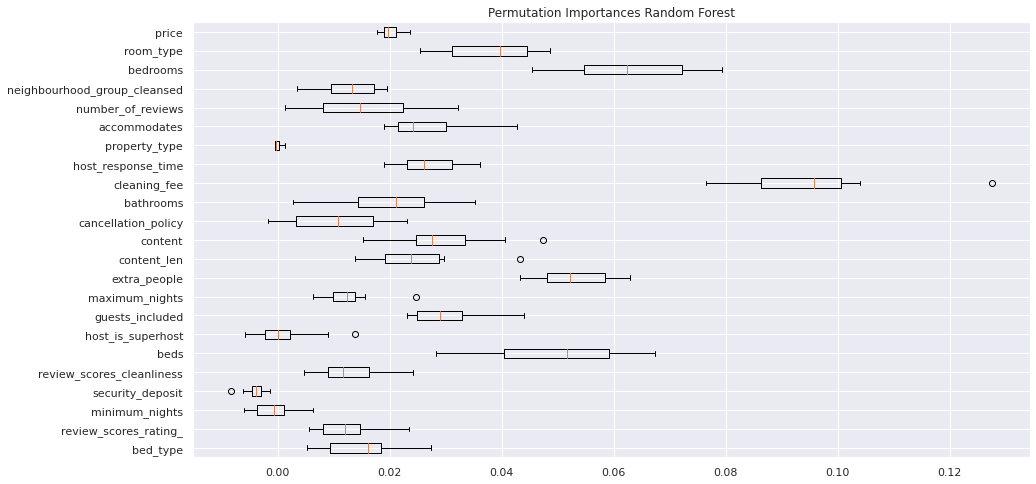

In [96]:
result_rf = permutation_importance(rf_bestmodel, X_test, y_test, n_repeats = 10, random_state =  2022)
sorted_index_rf = result_rf.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15, 8))
ax.boxplot(result.importances[sorted_index_rf].T, vert=False, labels=X.columns[sorted_index])

ax.set_title('Permutation Importances Random Forest')
fig.show()

In [97]:
perm_features_rf = pd.DataFrame(dict(feature_names = X_test.columns.tolist(),
                                  feature_importance = result_rf.importances_mean))
# Displaying importances from highest to lowest
perm_features_rf.sort_values('feature_importance', ascending=False)

,feature_names,feature_importance
20,content,0.125362
17,number_of_reviews,0.044151
4,room_type,0.034039
16,maximum_nights,0.017228
21,content_len,0.010018
0,host_response_time,0.007062
15,minimum_nights,0.003772
12,cleaning_fee,0.003659
10,price,0.003426
19,cancellation_policy,0.001548


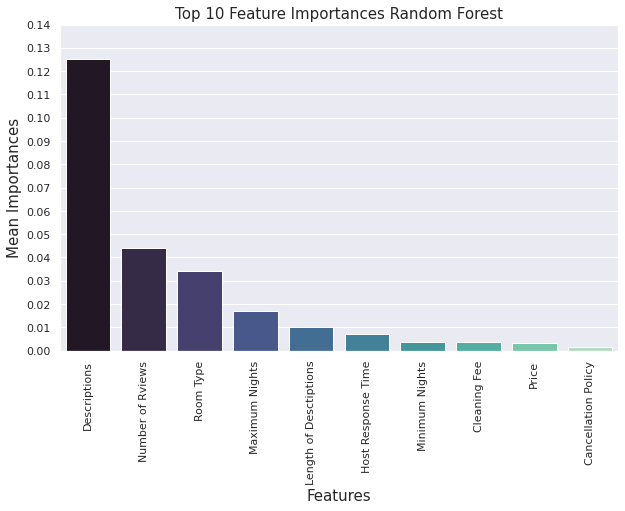

In [99]:
# The most important features for Random Forest
top_features = perm_features_rf.sort_values('feature_importance', ascending=False)[0:10]
top_names = ['Descriptions', 'Number of Rviews', 'Room Type', 'Maximum Nights', 'Length of Desctiptions', 'Host Response Time',
             'Minimum Nights', 'Cleaning Fee', 'Price', 'Cancellation Policy']
plt.figure(figsize=(10, 6))

ax = sns.barplot(x='feature_names', y='feature_importance', data=top_features, palette='mako')
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('Mean Importances', fontsize=15)
ax.set_title('Top 10 Feature Importances Random Forest', fontsize=15)
plt.xticks(range(len(top_names)), top_names, rotation=90, ha='center')
plt.yticks(np.arange(0, 0.15, step=0.010))
plt.show()

## Results

Support Vector Regression and Random Forest were the two best performing models on test data with Mean Squared Error of 10.8. Although Random Forest scored 0.11 on cross validation whereas SVR scored 0.10, it is important to evaluate what features contribute the most to booking rates with the two models. 

We see that different features have various effects on different models. Price followed by room type and number of bedrooms were the top predictors in SVR model whereas descriptions (NLP text data describing listings), number of reviews and room type were the top predictors in Random Forest. Descriptions have very large effect on booking rates at 12% compared to other features in Random Forest model. However we see that price has less effect 9.5% in SVR compared to descriptions in Random Forest model. We also see that room type is one of the top predictors in both models.

As a result, we can conlude that listing descriptions, price, room type, number of reviews and number of bedrooms are the top contibutors to booking rate. To hosts who want to increase their booking rate, I suggest putting more emphasis on these features, such as being more descriptive on their listing summary, lowering price during peak times such as summer and also getting more positive reviews by providing their guests a pleasant experience. 

## Contact 

For any further questions, please reach me:

### Hatice K. Erdogan

kastanhatice@gmail.com